<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_03_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

## Loading & Preprocesing Data

In [ ]:
# download dataset
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split='train')

In [ ]:
# save the dataset
dataset.save('/content/drive/MyDrive/malaria_dataset')

In [3]:
# load dataset

dataset = tf.data.Dataset.load('/content/drive/MyDrive/malaria_dataset')

In [4]:
len(dataset)

27558

In [5]:
# resize and rescale function
def resize_rescale(img, label):
  img = tf.image.resize(img, (224, 224))
  img = img/255.0
  return img, label

In [6]:
# Train Validation Test Split ratios
TRAIN_RATIO  =  0.8
VAL_RATIO    =  0.1
TEST_RATIO   =  0.1


# labels
labels = ["P", "U"]
# 1 -- > U --> Uninfacted
# 0 -- > P --> Parsitic

In [7]:
# train split
train_dataset = dataset.take(int(len(dataset)*TRAIN_RATIO))
print(f"train_dataset length : {len(train_dataset)}")

train_dataset length : 22046


In [8]:
# validation split
val_dataset = dataset.skip(int(len(dataset)*TRAIN_RATIO))
val_dataset = val_dataset.take(int(len(dataset)*VAL_RATIO))
print(f"val_dataset length : {len(val_dataset)}")

val_dataset length : 2755


In [9]:
# test split
test_dataset = dataset.skip(int(len(dataset)*(TEST_RATIO + VAL_RATIO)))
test_dataset = test_dataset.take(int(len(dataset)*TEST_RATIO))
print(f"test_dataset length : {len(test_dataset)}")

test_dataset length : 2755


In [10]:
# train dataset preparation
train_dataset = (train_dataset
                 .map(resize_rescale)
                 .shuffle(buffer_size= 16, reshuffle_each_iteration=True)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))


batch_1 = train_dataset.take(1)
for img, label in batch_1.take(3):
  print(f"Image : {img.shape}, label: {label.shape}")

Image : (32, 224, 224, 3), label: (32,)


In [11]:
# validation dataset preparation
validation_dataset = (val_dataset
                      .map(resize_rescale)
                      .shuffle(buffer_size= 16, reshuffle_each_iteration=True)
                      .batch(32)
                      .prefetch(tf.data.AUTOTUNE)
                      )


batch_1 = validation_dataset.take(1)
for img, label in batch_1.take(3):
  print(f"Image : {img.shape}, label: {label.shape}")

Image : (32, 224, 224, 3), label: (32,)


In [12]:
# test dataset preparation
test_dataset = (test_dataset
                .map(resize_rescale)
              )

## Model

In [13]:
# model architecture

temp_model = tf.keras.Sequential([

      tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),

      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.MaxPool2D(pool_size=2),

      tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
      tf.keras.layers.BatchNormalization(),


      tf.keras.layers.Flatten(),

      # tf.keras.layers.Dense(units=1000, activation='relu'),
      tf.keras.layers.Dense(units=100, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(units=10, activation='relu'),
      tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [14]:
# model summary
temp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 220, 220, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 216, 216, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 216, 216, 32)      128       
 chNormalization)                                       

## Compile & Train

In [15]:
# model compilation


metrix = [tf.keras.metrics.BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]


temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=metrix)

In [16]:
# train model
history = temp_model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1)

Epoch 1/3
689/689 [==============================] - 213s 277ms/step - loss: 0.2983 - binary_accuracy: 0.8872 - true_positives: 10024.0000 - true_negatives: 9536.0000 - false_positives: 1487.0000 - false_negatives: 999.0000 - val_loss: 0.3419 - val_binary_accuracy: 0.9085 - val_true_positives: 1343.0000 - val_true_negatives: 1160.0000 - val_false_positives: 203.0000 - val_false_negatives: 49.0000
Epoch 2/3
689/689 [==============================] - 179s 260ms/step - loss: 0.2033 - binary_accuracy: 0.9335 - true_positives: 10425.0000 - true_negatives: 10155.0000 - false_positives: 868.0000 - false_negatives: 598.0000 - val_loss: 0.3489 - val_binary_accuracy: 0.8755 - val_true_positives: 1379.0000 - val_true_negatives: 1033.0000 - val_false_positives: 330.0000 - val_false_negatives: 13.0000
Epoch 3/3
689/689 [==============================] - 182s 263ms/step - loss: 0.1721 - binary_accuracy: 0.9431 - true_positives: 10535.0000 - true_negatives: 10257.0000 - false_positives: 766.0000 - fa

## Result Visualization

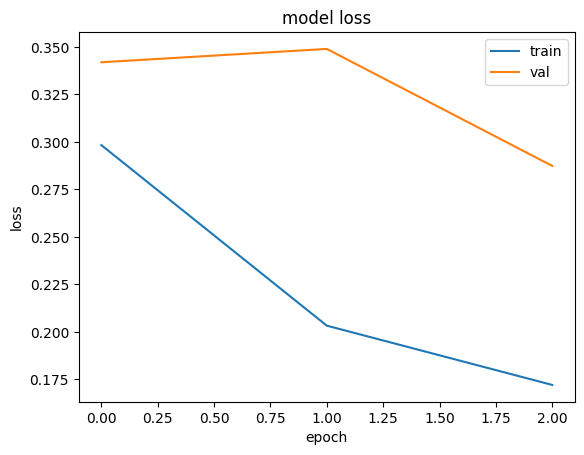

In [18]:
# Model Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

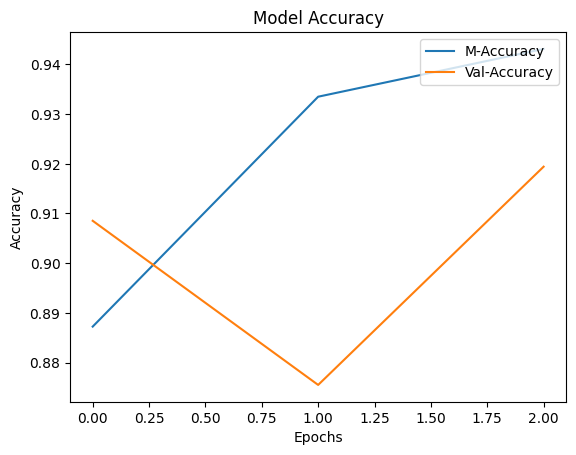

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['M-Accuracy', 'Val-Accuracy'], loc='upper right')
plt.show()

## Save & Load Model

In [ ]:
# save model

tf.keras.models.save_model(temp_model, '/content/drive/MyDrive/dl_revision/malaria_model.h5')

<ipython-input-26-0b341cbae446>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(temp_model, '/content/drive/MyDrive/dl_revision/malaria_model.h5')


In [13]:
# load model


malaria_model = tf.keras.models.load_model('/content/drive/MyDrive/dl_revision/malaria_model.h5')

## Testing

In [20]:
# evaluate Model

temp_model.evaluate(test_dataset.batch(32))

87/87 [==============================] - 6s 60ms/step - loss: 0.2708 - binary_accuracy: 0.9198 - true_positives: 1345.0000 - true_negatives: 1189.0000 - false_positives: 199.0000 - false_negatives: 22.0000


[0.2707885205745697, 0.9197822213172913, 1345.0, 1189.0, 199.0, 22.0]

In [21]:
example_1 = test_dataset.take(1)

img, label = next(iter(example_1))


temp_model.predict(tf.expand_dims(img, axis=0))

1/1 [==============================] - 1s 695ms/step


array([[0.9976071]], dtype=float32)

In [22]:
# def :-> base on the model threshold
# display model labels
def threshold_to_label(threshold):
  if threshold > 0.5:
    return labels[1]
  if threshold < 0.5:
    return labels[0]

1/1 [==============================] - 0s 23ms/step


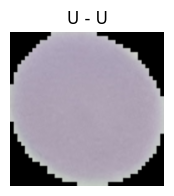

1/1 [==============================] - 0s 22ms/step


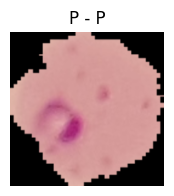

1/1 [==============================] - 0s 21ms/step


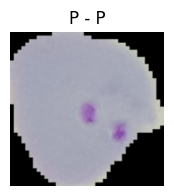

1/1 [==============================] - 0s 19ms/step


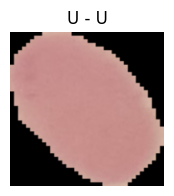

1/1 [==============================] - 0s 22ms/step


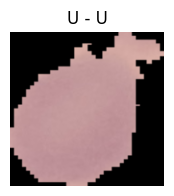

1/1 [==============================] - 0s 18ms/step


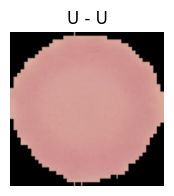

1/1 [==============================] - 0s 18ms/step


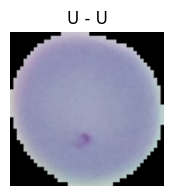

1/1 [==============================] - 0s 18ms/step


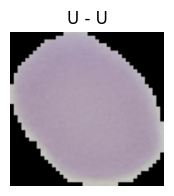

1/1 [==============================] - 0s 17ms/step


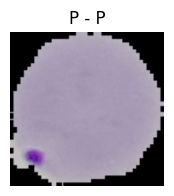

1/1 [==============================] - 0s 22ms/step


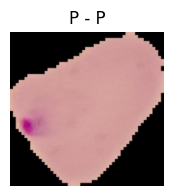

1/1 [==============================] - 0s 18ms/step


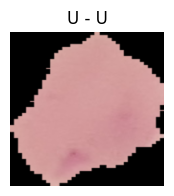

1/1 [==============================] - 0s 25ms/step


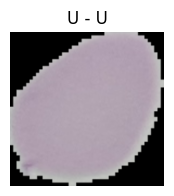

1/1 [==============================] - 0s 19ms/step


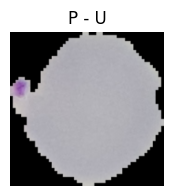

1/1 [==============================] - 0s 21ms/step


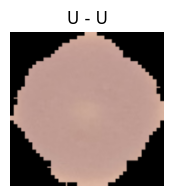

1/1 [==============================] - 0s 21ms/step


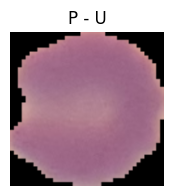

1/1 [==============================] - 0s 29ms/step


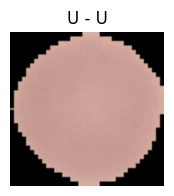

In [23]:
example_16 = test_dataset.take(16)

for image, label in example_16:
  pred = temp_model.predict(tf.expand_dims(image, axis=0))
  plt.figure(figsize=(2, 2))
  # plt.subplot(8, 2, i+1)
  plt.title(f"{threshold_to_label(label.numpy())} - {threshold_to_label(pred[0][0])}")
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  # break

### Model Evaluation

In [36]:
# Extracting test example labels
labels = []   # stores labels

for _, label in test_dataset:
  labels.append(label.numpy())

labels = np.array(labels)

In [40]:
# Extracting test example predictions
preds = []  # stores model predictions


for img, _ in test_dataset:
  pred = temp_model.predict(tf.expand_dims(img, axis=0))
  preds.append(pred[0][0])

preds = np.array(preds)

1/1 [==============================] - 0s 19ms/step


[[1305   83]
 [ 104 1263]]


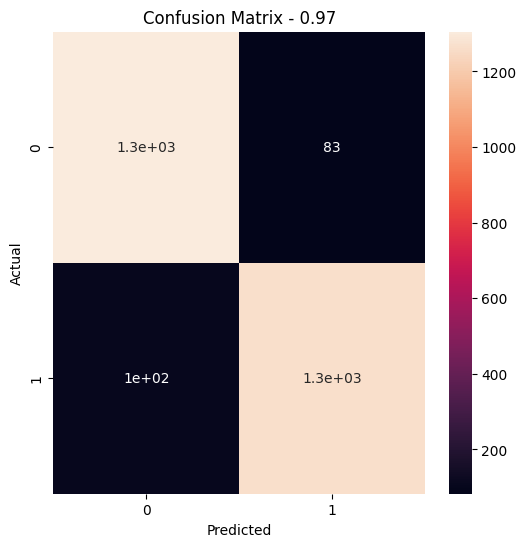

In [65]:
# Confusion Matrix
threshold = 0.97

conf_matrix = confusion_matrix(labels, preds > threshold)
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix - {}".format(threshold))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

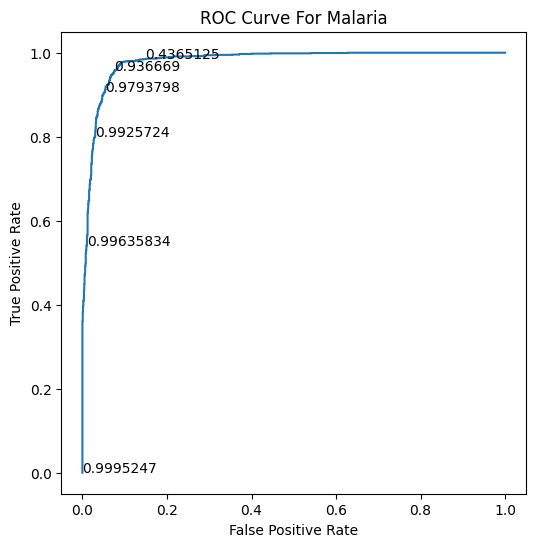

<function matplotlib.pyplot.show(close=None, block=None)>

In [62]:
# roc

skip = 50
fp, tp, threshold = roc_curve(labels, preds)

plt.figure(figsize=(6, 6))
plt.title("ROC Curve For Malaria")
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
for i in range(1, len(fp), skip):
  plt.annotate(threshold[i], (fp[i], tp[i]))

plt.show()

plt.show